# Autoscaling multi-tenant Kubernetes Deep-Dive

In this example we are going to take a deep-dive into launching an autoscaling multi-tenant RAPIDS environment on Kubernetes.

Being able to scale out your workloads and only pay for the resources you use is a fantastic way to save costs when using RAPIDS. If you have many folks in your organization who all want to be able to do this you can get added benefits by pooling your resources into an autoscaling Kubernetes cluster.

Let's run through the steps required to launch a Kubernetes cluster on [Google Cloud](https://cloud.google.com), then simulate the workloads of many users sharing the cluster. Then we can explore what that experience was like both from a user perspective and also from a cost perspective.

### Prerequisites

Before we get started you'll need to ensure you have a few CLI tools installed.

- [`gcloud`](https://cloud.google.com/sdk/gcloud) (and make sure you run [`gcloud auth login`](https://cloud.google.com/sdk/gcloud/reference/auth/login))
- [`kubectl`](https://kubernetes.io/docs/tasks/tools/)
- [`helm`](https://helm.sh/docs/intro/install/)

## Get a Kubernetes Cluster

For this example we are going to use [Google Cloud's Google Kubernetes Engine (GKE)](https://cloud.google.com/kubernetes-engine) to launch a cluster.

````{docref} /cloud/gcp/gke
We are going to follow the RAPIDS GKE deployment instructions but we will modify our cluster creation command to enable Kubernetes cluster autoscaling out of the box.

```
--enable-autoscaling --autoscaling-profile optimize-utilization \
--num-nodes 1 --min-nodes 1 --max-nodes 20
```

Data science container images are also notiriously large so we will enable image streaming to speed up our container creation.

```
--image-type="COS_CONTAINERD" --enable-image-streaming
```
````

In [44]:
! gcloud container clusters create multi-tenant-rapids \
    --accelerator type=nvidia-tesla-t4,count=2 --machine-type n1-standard-4 \
    --region us-central1 --node-locations us-central1-b,us-central1-c \
    --release-channel stable \
    --enable-autoscaling --autoscaling-profile optimize-utilization \
    --num-nodes 1 --min-nodes 1 --max-nodes 20 \
    --image-type="COS_CONTAINERD" --enable-image-streaming

Default change: VPC-native is the default mode during cluster creation for versions greater than 1.21.0-gke.1500. To create advanced routes based clusters, please pass the `--no-enable-ip-alias` flag
Default change: During creation of nodepools or autoscaling configuration changes for cluster versions greater than 1.24.1-gke.800 a default location policy is applied. For Spot and PVM it defaults to ANY, and for all other VM kinds a BALANCED policy is used. To change the default values use the `--location-policy` flag.
Note: Your Pod address range (`--cluster-ipv4-cidr`) can accommodate at most 1008 node(s).
Note: Machines with GPUs have certain limitations which may affect your workflow. Learn more at https://cloud.google.com/kubernetes-engine/docs/how-to/gpus
Creating cluster multi-tenant-rapids in us-central1... Cluster is being configu
red...⠼                                                                        
Creating cluster multi-tenant-rapids in us-central1... Cluster is bein

Now that we have our cluster let's [install the NVIDIA Drivers](https://cloud.google.com/kubernetes-engine/docs/how-to/gpus#installing_drivers).

In [45]:
! kubectl apply -f https://raw.githubusercontent.com/GoogleCloudPlatform/container-engine-accelerators/master/nvidia-driver-installer/cos/daemonset-preloaded-latest.yaml

daemonset.apps/nvidia-driver-installer created


## Observability

Once we have run some workloads on our Kubernetes cluster we will want to be able to go back through the cluster telemetry data to see how our autoscaling behaved. To do this let's install [Prometheus](https://prometheus.io/) so that we are recording cluster metrics and can explore them later.

### Prometheus stack

Let's start by installing the [Kubernetes Prometheus Stack](https://github.com/prometheus-community/helm-charts/tree/main/charts/kube-prometheus-stack) which includes everything we need to run Prometheus on our cluster.

We need to add a couple of extra configuration options to ensure Prometheus is collecting data frequently enough to analyse, which you will find in `prometheus-stack-values.yaml`.

In [65]:
! cat prometheus-stack-values.yaml

# prometheus-stack-values.yaml
serviceMonitorSelectorNilUsesHelmValues: false

prometheus:
  prometheusSpec:
    # Setting this to a high frequency so that we have richer data for analysis later
    scrapeInterval: 1s


In [46]:
! helm install --repo https://prometheus-community.github.io/helm-charts kube-prometheus-stack kube-prometheus-stack \
   --create-namespace --namespace prometheus \
   --values prometheus-stack-values.yaml

NAME: kube-prometheus-stack
LAST DEPLOYED: Tue Feb 21 09:19:39 2023
NAMESPACE: prometheus
STATUS: deployed
REVISION: 1
NOTES:
kube-prometheus-stack has been installed. Check its status by running:
  kubectl --namespace prometheus get pods -l "release=kube-prometheus-stack"

Visit https://github.com/prometheus-operator/kube-prometheus for instructions on how to create & configure Alertmanager and Prometheus instances using the Operator.


Now that we have Prometheus running and collecting data we can move on and install RAPIDS and run some workloads. We will come back to these tools later when we want to explore the data we have collected.

## Install RAPIDS

For this RAPIDS installation we are going to use a single [Jupyter Notebook Pod](/platforms/kubernetes) and the [Dask Operator](/tools/kubernetes/dask-operator). In a real deployment you would use something like [JupyterHub](https://jupyter.org/hub) or [Kubeflow Notebooks](https://www.kubeflow.org/docs/components/notebooks/) to create a notebook spawning service with user authentication, but that is out of scope for this example.

```{docref} /platforms/kubernetes
There are many ways to install RAPIDS on Kubernetes. You can find detailed instructions on all of the various methods in the documentation.
```

### Image steaming (optional)

In order to steam the container image to the GKE nodes our image needs to be stored in [Google Cloud Artifact Registry](https://cloud.google.com/artifact-registry/) in the same region as our cluster.

```console
$ docker pull rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10

$ docker tag rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10 REGION-docker.pkg.dev/PROJECT/REPO/IMAGE:TAG

$ docker push REGION-docker.pkg.dev/PROJECT/REPO/IMAGE:TAG
```

Be sure to replace the image throughout the notebook with the one that you have pushed to your own Google Cloud project.

### Image prepuller (optional)

If you know that many users are going to want to frequently pull a specific container image I like to run a small `DaemonSet` which ensures that image starts streaming onto a node as soon as it joins the cluster. This is optional but can reduce wait time for users.

In [39]:
! cat image-prepuller.yaml

# image-prepuller.yaml
apiVersion: apps/v1
kind: DaemonSet
metadata:
  name: prepull-rapids
spec:
  selector:
    matchLabels:
      name: prepull-rapids
  template:
    metadata:
      labels:
        name: prepull-rapids
    spec:
      initContainers:
        - name: prepull-rapids
          image: rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10
          command: ["sh", "-c", "'true'"]
      containers:
        - name: pause
          image: gcr.io/google_containers/pause


In [48]:
! kubectl apply -f image-prepuller.yaml

daemonset.apps/prepull-rapids created


### RAPIDS Notebook Pod

Now let's launch a Notebook Pod. 

````{note}
From this Pod we are going to want to be able to spawn Dask cluster resources on Kubernetes, so we need to ensure the Pod has the appropriate permissions to interact with the Kubernetes API. 

```{docref} /platforms/kubernetes
Check out the extended notebook contiguration documentation for more details.
```
````

In [49]:
! kubectl apply -f rapids-notebook.yaml

serviceaccount/rapids-dask created
role.rbac.authorization.k8s.io/rapids-dask created
rolebinding.rbac.authorization.k8s.io/rapids-dask created
configmap/jupyter-server-proxy-config created
service/rapids-notebook created
pod/rapids-notebook created


### Install the Dask Operator

Lastly we need to install the Dask Operator so we can spawn RAPIDS Dask cluster from our Notebook session.

```{docref} /tools/kubernetes/dask-operator
See the RAPIDS Dask Operator documentation for more information.
```

In [50]:
! helm install --repo https://helm.dask.org dask-kubernetes-operator \
    --generate-name --create-namespace --namespace dask-operator 

NAME: dask-kubernetes-operator-1676971371
LAST DEPLOYED: Tue Feb 21 09:23:06 2023
NAMESPACE: dask-operator
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
Operator has been installed successfully.


## Running some work

Next let's connect to the Jupyter session and run some work on our cluster. You can do this by port forwarding the Jupyter service to your local machine.

```console
$ kubectl port-forward svc/rapids-notebook 8888:8888                                                                                                                        
Forwarding from 127.0.0.1:8888 -> 8888
Forwarding from [::1]:8888 -> 8888
```

Then open http://localhost:8888 in your browser.

```{note}
If you are following along with this notebook locally you will also want to upload it to the Jupyter session and continue running the cells from there.
```

### Check our capabilities

Let's make sure our environment is all set up correctly by checking out our capabilities. We can start by running `nvidia-smi` to inspect our Notebook GPU.

In [1]:
! nvidia-smi

Tue Feb 21 14:50:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Great we can see our notebook has an NVIDIA T4. Now let's use `kubectl` to inspect our cluster. We won't actually have `kubectl` installed in our remote Jupyter environment so let's do that first.

In [2]:
! mamba install --quiet -c conda-forge kubernetes-client -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [3]:
! kubectl get pods

NAME                   READY   STATUS    RESTARTS   AGE
prepull-rapids-l5qgt   1/1     Running   0          3m24s
prepull-rapids-w8xcj   1/1     Running   0          3m24s
rapids-notebook        1/1     Running   0          2m54s


We can see our prepull Pods we created earlier alongside our `rapids-notebook` Pod that we are currently in. As we created the prepull Pod via a `DaemonSet` we also know that there are two nodes in our Kubernetes cluster because there are two prepull Pods. As our cluster scales we will see more of them appear.

In [5]:
! kubectl get daskclusters

No resources found in default namespace.


We can also see that we currently have no `DaskCluster` resources, but this is good because we didn't get a `server doesn't have a resource type "daskclusters"` error so we know the Dask Operator also installed successfully.

### Small workload

Let's run a small RAPIDS workload that stretches our Kubernetes cluster a little and causes it to scale. 

We know that we have two nodes in our Kubernetes cluster and we selected a node type with 2 GPUs when we launched it on GKE. Our Notebook Pod is taking up one GPU so we have three remaining. If we launch a Dask Cluster we will need one GPU for the scheduler and one for each worker. So let's create a Dask cluster with four workers which will cause our Kubernetes to add one more node.

First let's install `dask-kubernetes` so we can create our `DaskCluster` resources from Python. We will also install `gcsfs` so that our workload can read data from [Google Cloud Storage](https://cloud.google.com/storage).

In [6]:
! mamba install --quiet -c conda-forge dask-kubernetes gcsfs -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [7]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(
    name="rapids-dask-1",
    image="rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10",  # Replace me with your cached image
    n_workers=4,
    resources={"limits": {"nvidia.com/gpu": "1"}},
    env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs"},
    worker_command="dask-cuda-worker",
)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f81225ac820>
Unclosed connection
client_connection: Connection<ConnectionKey(host='10.32.0.1', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


Great our Dask cluster was created but right now we just have a scheduler with half of our workers. We can use `kubectl` to see what is happening.

In [12]:
! kubectl get pods

NAME                                      READY   STATUS    RESTARTS   AGE
prepull-rapids-l5qgt                      1/1     Running   0          6m18s
prepull-rapids-w8xcj                      1/1     Running   0          6m18s
rapids-dask-1-default-worker-5f59bc8e7a   0/1     Pending   0          68s
rapids-dask-1-default-worker-88ab088b7c   0/1     Pending   0          68s
rapids-dask-1-default-worker-b700343afe   1/1     Running   0          68s
rapids-dask-1-default-worker-e0bb7fff2d   1/1     Running   0          68s
rapids-dask-1-scheduler                   1/1     Running   0          69s
rapids-notebook                           1/1     Running   0          5m48s


We see here that most of our Pods are `Running` but two workers are `Pending`. This is because we don't have enough GPUs for them right now. We can look at the events on our pending pods for more information.

In [11]:
! kubectl get event --field-selector involvedObject.name=rapids-dask-1-default-worker-5f59bc8e7a

LAST SEEN   TYPE      REASON             OBJECT                                        MESSAGE
50s         Warning   FailedScheduling   pod/rapids-dask-1-default-worker-5f59bc8e7a   0/2 nodes are available: 2 Insufficient nvidia.com/gpu.
12s         Normal    TriggeredScaleUp   pod/rapids-dask-1-default-worker-5f59bc8e7a   pod triggered scale-up: [{https://www.googleapis.com/compute/v1/projects/nv-ai-infra/zones/us-central1-b/instanceGroups/gke-multi-tenant-rapids-default-pool-3a6a793f-grp 1->2 (max: 20)}]


Here we can see that our Pod triggered the cluster to scale from one to two nodes. If we wait for our new node to come online we should see a few things happen. 

- First there will be a new prepull Pod scheduled on the new node which will start streaming the RAPIDS container image.
- Other Pods in the `kube-system` namespace will be scheduled to install NVIDIA drivers and update the Kubernetes API.
- Then once the GPU drivers have finished installing the worker Pods will be scheduled onto our new node
- Then once the image is ready our Pods move into a `Running` phase.

In [13]:
! kubectl get pods -w

NAME                                      READY   STATUS    RESTARTS   AGE
prepull-rapids-l5qgt                      1/1     Running   0          6m41s
prepull-rapids-w8xcj                      1/1     Running   0          6m41s
rapids-dask-1-default-worker-5f59bc8e7a   0/1     Pending   0          91s
rapids-dask-1-default-worker-88ab088b7c   0/1     Pending   0          91s
rapids-dask-1-default-worker-b700343afe   1/1     Running   0          91s
rapids-dask-1-default-worker-e0bb7fff2d   1/1     Running   0          91s
rapids-dask-1-scheduler                   1/1     Running   0          92s
rapids-notebook                           1/1     Running   0          6m11s
prepull-rapids-69pbq                      0/1     Pending   0          0s
prepull-rapids-69pbq                      0/1     Pending   0          0s
prepull-rapids-69pbq                      0/1     Init:0/1   0          4s
rapids-dask-1-default-worker-88ab088b7c   0/1     Pending    0          2m3s
prepull-rapids-69pb

Awesome we can now run some work on our Dask cluster.

In [14]:
from dask.distributed import Client, wait

client = Client(cluster)
client

<Client: 'tcp://10.28.1.6:8786' processes=2 threads=2, memory=29.30 GiB>

Let's load some data from GCS into memory on our GPUs.

In [ ]:
%%time
import dask.config
import dask.dataframe as dd

dask.config.set({"dataframe.backend": "cudf"})

df = dd.read_parquet(
    "gcs://anaconda-public-data/nyc-taxi/2015.parquet",
    storage_options={"token": "cloud"},
).persist()
wait(df)
df

Now we can do some calculation. This can be whatever you want to do with your data, for this example let's do something quick like calculating the haversine distance between the pickup and dropoff locations (yes calculating this on ~100M rows is a quick task for RAPIDS 😁).

In [ ]:
from cuspatial import haversine_distance


def map_haversine(part):
    return haversine_distance(
        part["pickup_longitude"],
        part["pickup_latitude"],
        part["dropoff_longitude"],
        part["dropoff_latitude"],
    )


df["haversine_distance"] = df.map_partitions(map_haversine)

In [18]:
%%time
df["haversine_distance"].compute()

CPU times: user 1.44 s, sys: 853 ms, total: 2.29 s
Wall time: 4.66 s


tpep_pickup_datetime
2015-01-01 00:00:00       4.326464
2015-01-01 00:00:00    8666.633292
2015-01-01 00:00:00       1.285498
2015-01-01 00:00:01       0.827326
2015-01-01 00:00:03       2.267110
                          ...     
2015-12-31 23:59:56       1.570824
2015-12-31 23:59:58       2.340270
2015-12-31 23:59:59       2.801575
2015-12-31 23:59:59       5.091840
2015-12-31 23:59:59       0.927577
Name: haversine_distance, Length: 146112989, dtype: float64

Great, so we now have a little toy workloads that opens some data, does some calculation and takes a bit of time.

Let's remove our single Dask cluster and switch to simulating many workloads running at once.

In [19]:
client.close()
cluster.close()

## Simulating many multi-tenant workloads

Now we have a toy workload which we can use to represent one user on our multi-tenant cluster.

Let's now construct a larger graph to simulate lots of users spinning up Dask clusters and running workloads.

First let's create a function that contains our whole workload including our cluster setup.

In [31]:
import dask.delayed


@dask.delayed
def run_haversine(*args):
    from dask_kubernetes.operator import KubeCluster
    from dask.distributed import Client, wait
    import uuid
    import dask.config
    import dask.dataframe as dd

    dask.config.set({"dataframe.backend": "cudf"})

    def map_haversine(part):
        from cuspatial import haversine_distance

        return haversine_distance(
            part["pickup_longitude"],
            part["pickup_latitude"],
            part["dropoff_longitude"],
            part["dropoff_latitude"],
        )

    with KubeCluster(
        name="rapids-dask-" + uuid.uuid4().hex[:5],
        image="rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10",  # Replace me with your cached image
        n_workers=2,
        resources={"limits": {"nvidia.com/gpu": "1"}},
        env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs"},
        worker_command="dask-cuda-worker",
        resource_timeout=600,
    ) as cluster:
        with Client(cluster) as client:
            client.wait_for_workers(2)
            df = dd.read_parquet(
                "gcs://anaconda-public-data/nyc-taxi/2015.parquet",
                storage_options={"token": "cloud"},
            )
            client.compute(df.map_partitions(map_haversine))

Now if we run this function we will launch a Dask cluster and run our workload. We will use context managers to ensure our Dask cluster gets cleaned up when the work is complete. Given that we have no active Dask clusters this function will be executed on the Notebook Pod.

In [17]:
%%time
run_haversine().compute()

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fd0f4b8b340>
Unclosed connection
client_connection: Connection<ConnectionKey(host='10.32.0.1', port=443, is_ssl=True, ssl=None, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


CPU times: user 194 ms, sys: 30 ms, total: 224 ms
Wall time: 23.6 s


Great that works, so we have a self contained RAPIDS workload that launches its own Dask cluster and performs some work.

### Simulating our multi-tenant workloads

To see how our Kubernetes cluster behaves when many users are sharing it we want to run our haversine workload a bunch of times. 

```{note}
If you're not interested in how we simulate this workload feel free to skip onto the analysis section.
```

To do this we can create another Dask cluster which we will use to pilot our workloads. This cluster will be a proxy for the Jupyter sessions our users would be interacting with. Then we will construct a Dask graph which runs our haversine workload many times in various configurations to simulate different users submitting different workloads on an ad-hoc basis.

In [35]:
from dask_kubernetes.operator import KubeCluster, make_cluster_spec

cluster_spec = make_cluster_spec(
    name="mock-jupyter-cluster",
    image="rapidsai/rapidsai-core:23.02-cuda11.8-runtime-ubuntu22.04-py3.10",  # Replace me with your cached image
    n_workers=1,
    resources={"limits": {"nvidia.com/gpu": "1"}, "requests": {"cpu": "50m"}},
    env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "gcsfs dask-kubernetes"},
)
cluster_spec["spec"]["worker"]["spec"]["serviceAccountName"] = "rapids-dask"

cluster = KubeCluster(custom_cluster_spec=cluster_spec)
cluster

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f80300cfd30>


Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.28.1.12:8786,Workers: 0
Dashboard: /proxy/10.28.1.12:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


We need to ensure our workers have the same dependencies as our Notebook session here so that it can spawn more Dask clusters so we install `gcsfs` and `dask-kubernetes`.

In [36]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,
Dashboard: /proxy/mock-jupyter-cluster-scheduler.default:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.28.1.12:8786,Workers: 0
Dashboard: /proxy/10.28.1.12:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Now lets submit our workload again but this time to our cluster. Our function will be sent to our "Jupyter" worker which will then spawn another Dask cluster to run the workload. We don't have enough GPUs in our cluster to do this so it will trigger another scale operation.

In [20]:
%%time
run_haversine().compute()

CPU times: user 950 ms, sys: 9.1 ms, total: 959 ms
Wall time: 27.1 s


Now let's write a small function which we can use to build up arbitrarily complex workloads. We can define how many stages we have, how many concurrent Dask clusters their should be, how quickly to vary width over time, etc.

In [22]:
from random import randrange


def generate_workload(
    stages=3, min_width=1, max_width=3, variation=1, input_workload=None
):
    graph = [input_workload] if input_workload is not None else [run_haversine()]
    last_width = min_width
    for stage in range(stages):
        width = randrange(
            max(min_width, last_width - variation),
            min(max_width, last_width + variation) + 1,
        )
        graph = [run_haversine(*graph) for _ in range(width)]
        last_width = width
    return run_haversine(*graph)

In [37]:
cluster.scale(3)  # Let's also bump up our user cluster to show more users logging in.

To visualize our graphs let's check that we have `graphviz` installed.

In [23]:
!mamba install -c conda-forge --quiet graphviz python-graphviz -y

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 

done


Let's start with a small workload which will run a couple of stages and trigger a scale up.

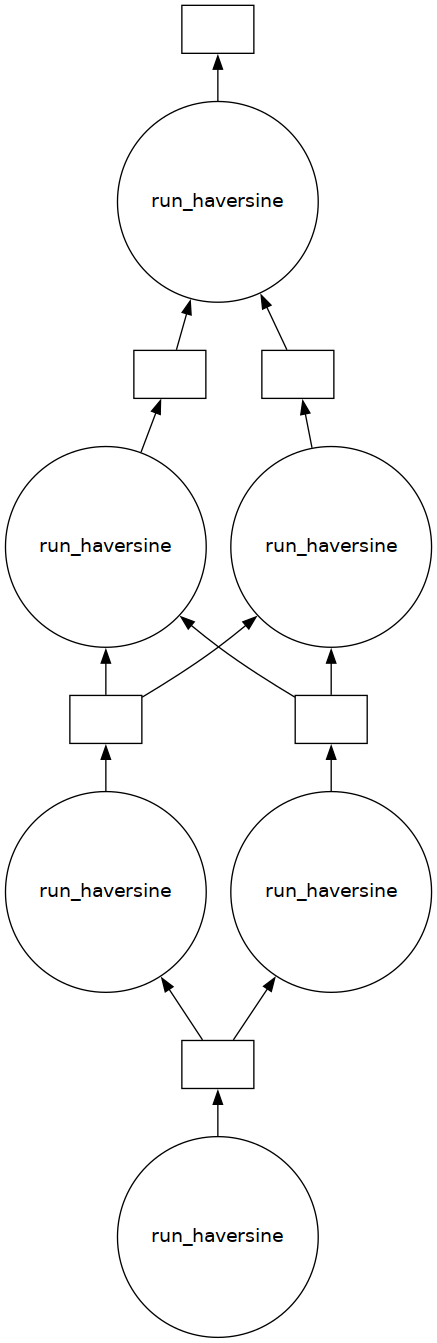

In [35]:
workload = generate_workload(stages=2, max_width=2)
workload.visualize()

This is great we have multiple stages where one or two users are running workloads at the same time. Now lets chain a bunch of these workloads together to simulate varying demands over a larger period of time.

We will also track the start and end times of the run so that we can grab the right data from Prometheus later.

In [24]:
import datetime

```{warning}
The next cell will take around 1h to run.
```

In [38]:
%%time
start_time = (datetime.datetime.now() - datetime.timedelta(minutes=15)).strftime(
    "%Y-%m-%dT%H:%M:%SZ"
)
try:
    # Start with a couple of concurrent workloads
    workload = generate_workload(stages=10, max_width=2)
    # Then increase demand as more users appear
    workload = generate_workload(
        stages=5, max_width=5, min_width=3, variation=5, input_workload=workload
    )
    # Now reduce the workload for a longer period of time, this could be over a lunchbreak or something
    workload = generate_workload(stages=30, max_width=2, input_workload=workload)
    # Everyone is back from lunch and it hitting the cluster hard
    workload = generate_workload(
        stages=10, max_width=10, min_width=3, variation=5, input_workload=workload
    )
    # The after lunch rush is easing
    workload = generate_workload(
        stages=5, max_width=5, min_width=3, variation=5, input_workload=workload
    )
    # As we get towards the end of the day demand slows off again
    workload = generate_workload(stages=10, max_width=2, input_workload=workload)
    workload.compute()
finally:
    client.close()
    cluster.close()
    end_time = (datetime.datetime.now() + datetime.timedelta(minutes=15)).strftime(
        "%Y-%m-%dT%H:%M:%SZ"
    )

Task exception was never retrieved
future: <Task finished name='Task-724' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


CPU times: user 2min 43s, sys: 3.04 s, total: 2min 46s
Wall time: 1h 18min 18s


Ok great, our large graph of workloads resulted in ~200 clusters launching throughout the run with varying capacity demands and took just over an hour to run.

## Analysis

Let's explore the data we've been collecting with Prometheus to see how our cluster perforumed during our simulated workload. We could do this in [Grafana](https://grafana.com/), but instead let's stay in the notebook and use `prometheus-pandas`.

In [39]:
! pip install prometheus-pandas

Connect to the prometheus endpoint within our cluster.

In [41]:
from prometheus_pandas import query

p = query.Prometheus("http://kube-prometheus-stack-prometheus.prometheus:9090")

### Pending pods

First let's see how long each of our Pods spent in a `Pending` phase. This is the amount of time users would have to wait for their work to start running when they create their Dask clusters.

In [42]:
pending_pods = p.query_range(
    'kube_pod_status_phase{phase="Pending",namespace="default"}',
    start_time,
    end_time,
    "1s",
).sum()

In [43]:
from dask.utils import format_time

Average time for Pod creation.

In [44]:
format_time(pending_pods.median())

'2.00 s'

In [45]:
format_time(pending_pods.mean())

'22.35 s'

99th percentile time for Pod creation.

In [46]:
format_time(pending_pods.quantile(0.99))

'326.00 s'

These numbers seem great, the most common start time for a cluster is two seconds! With the average being around 20 seconds. If your cluster triggers Kubernetes to scale up you could be waiting for 5 minutes though. Let's see how many users would end up in that situation.

What percentage of users get workers in less than 2 seconds, 5 seconds, 60 seconds, etc?

In [47]:
from scipy import stats

stats.percentileofscore(pending_pods, 2.01)

59.70873786407767

In [48]:
stats.percentileofscore(pending_pods, 5.01)

72.00647249190939

In [49]:
stats.percentileofscore(pending_pods, 60.01)

91.10032362459548

Ok this looks pretty reasonable. Nearly 75% of users get a cluster in less than 5 seconds, and over 90% get it in under a minute. But if you're in the other 10% you may have to wait for 5 minutes.

Let's bucket this data to see the distribution of startup times visually.

Text(0, 0.5, 'Pods')

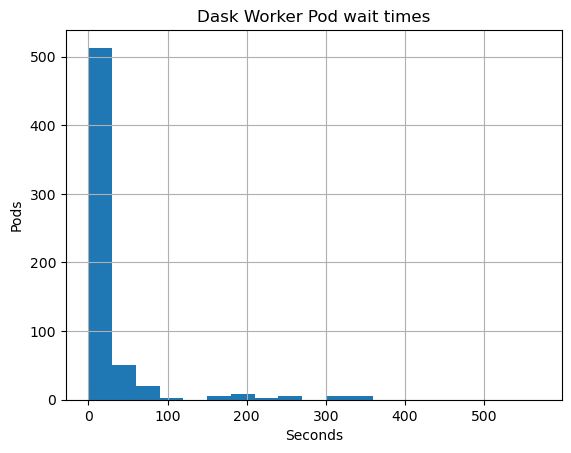

In [52]:
ax = pending_pods.hist(bins=range(0, 600, 30))
ax.set_title("Dask Worker Pod wait times")
ax.set_xlabel("Seconds")
ax.set_ylabel("Pods")

Text(0, 0.5, 'Pods')

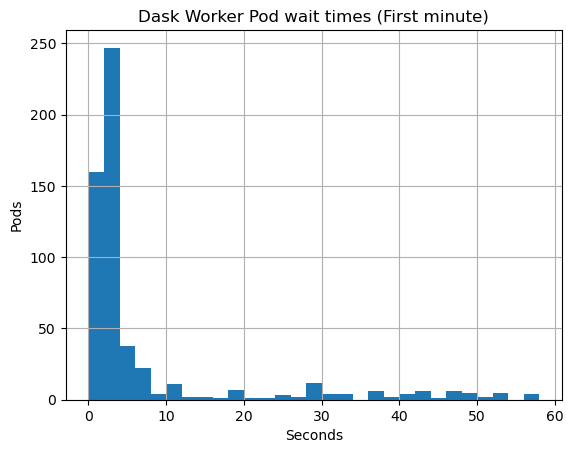

In [53]:
ax = pending_pods.hist(bins=range(0, 60, 2))
ax.set_title("Dask Worker Pod wait times (First minute)")
ax.set_xlabel("Seconds")
ax.set_ylabel("Pods")

Here we can see clearly that most users get their worker Pods scheduled in less than 5 seconds. 

### Cluster scaling and efficiency

Ok so our users are getting clusters nice and quick, that's because there is some warm capacity in the Kubernetes cluster that they are able to grab. When the limit is reached GKE autoscales to add new nodes. When demand drops for a while capacity is released again to save cost. 

Lets query to see how many nodes there were during the run and combine that with the number of running GPU Pods there were to see how efficiently we were using our resources.

In [ ]:
running_pods = p.query_range(
    'kube_pod_status_phase{phase=~"Running|ContainerCreating",namespace="default"}',
    start_time,
    end_time,
    "1s",
)
running_pods = running_pods[
    running_pods.columns.drop(list(running_pods.filter(regex="prepull")))
]
nodes = p.query_range("count(kube_node_info)", start_time, end_time, "1s")
nodes.columns = ["Available GPUs"]
nodes["Available GPUs"] = (
    nodes["Available GPUs"] * 2
)  # We know our nodes each had 2 GPUs
nodes["Utilized GPUs"] = running_pods.sum(axis=1)

<AxesSubplot: >

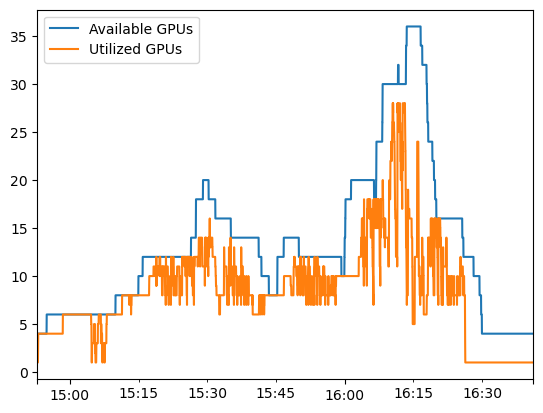

In [59]:
nodes.plot()

Excellent so we can see our cluster adding and removing nodes as our workload demand changed. The space between the orange and blue lines is our warm capacity. Ideally we want this to be as small as possible. Let's calculate what the gap is.

How many GPU hours did our users utilize?

In [60]:
gpu_hours_utilized = nodes["Utilized GPUs"].sum() / 60 / 60
gpu_hours_utilized

15.208055555555555

How many GPU hours were we charged for?

In [61]:
gpu_hours_cost = nodes["Available GPUs"].sum() / 60 / 60
gpu_hours_cost

23.938333333333333

What was the overhead?

In [63]:
overhead = (1 - (gpu_hours_utilized / gpu_hours_cost)) * 100
str(int(overhead)) + "% overhead"

'36% overhead'

Ok not bad, so on our interactive cluster we managed 64% utilization of our GPU resources. Compared to non-autoscaling workloads where users interactively use long running workstations and clusters this is fantastic.

If we measured batch workloads that ran for longer periods we would see this utilization clumb much higher.

## Closing thoughts

By sharing a Kubernetes cluster between many users who are all launching many ephemeral Dask Clusters to perform their work we are able to balance cost vs user time. Peaks in individual user demands get smoothed out over time in a multi-tenant model, and the overall peaks and troughs of the day are accomodated by the Kubernetes cluster autoscaler.

We managed to create a responsive experience for our users where they generally got Dask clusters in a few seconds. We also managed to hit 64% utilization of the GPUs in our cluster, a very respectable number for an interactive cluster. 

There are more things we could tune to increase utilization, but there are also some tradeoffs to be made here. If we scale down more aggressively then we would end up needing to scale back up more often resulting in more users waiting longer for their clusters. 

We can also see there there is some unused capacity between the nodes starting and our workload running. This is the time when image pulling happens, drivers get installed, etc. There are definitely things we could do to improve this so that nodes are ready to go as soon as they have booted.

Compared to every user spinning up dedicated nodes for their individual workloads and paying the driver install and environment pull wait time and overhead cost every time, we are pooling our resources and reusing our capacity effectively.

## Teardown

Finally to clean everything up we can delete our GKE cluster by running the following command locally.

In [43]:
! gcloud container clusters delete multi-tenant-rapids --region us-central1 --quiet

Deleting cluster multi-tenant-rapids...done.                                   
Deleted [https://container.googleapis.com/v1/projects/nv-ai-infra/zones/us-central1/clusters/multi-tenant-rapids].
